In [27]:
import os
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import ZivotAndrews
import importlib
import industry_indexes
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error

In [28]:
# Function to fetch stock data and calculate additional metrics
def fetch_data(ticker, start, end):
    try:
        # Fetch historical stock data
        stock_data = yf.download(ticker, start=start, end=end)
        
        # Fetch additional data using Ticker object
        ticker_obj = yf.Ticker(ticker)
        info = ticker_obj.info
        
        # Calculate Change and Change Percentage
        stock_data['Change'] = stock_data['Close'].diff()  # Daily Change
        stock_data['Change (%)'] = stock_data['Close'].pct_change() * 100  # Change percentage
        
        # Calculate log returns
        stock_data['Log Returns'] = (stock_data['Close'].pct_change() + 1).apply(np.log)  # Daily Log Return

        # Normalize the log returns (Z-score normalization)
        stock_data['Normalized Log Returns'] = (stock_data['Log Returns'] - stock_data['Log Returns'].mean()) / stock_data['Log Returns'].std()
        

        # stock_data['rClose'] = stock_data['Close'].pct_change(1)
        # stock_data['rrClose'] = stock_data['rClose'].pct_change(1)

        stock_data['dClose'] = stock_data['Close'].diff(1)  # First difference 
        stock_data['ddClose'] = stock_data['dClose'].diff(1)  # Second difference 

        return stock_data
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [29]:
# Function to save DataFrame to Excel file
def save_to_excel(df, filename):
    df.to_excel(filename)
    print(f"Data saved to {filename}")

In [30]:
# Function to display index data, plot Close price, and save to Excel
def fetch_indexes(market_type):
    global selected_indexes  # Declare it as global here
    indexes = {
        'US': ['^GSPC', '^DJI', '^IXIC'],  # S&P 500, Dow Jones, Nasdaq
        'International': ['^FTSE', '^GDAXI', '^N225', '^FCHI']  
    }

    # Fetch index data for the selected market type
    selected_indexes = indexes.get(market_type, [])
    
    if selected_indexes:
        print(f"Fetching data for the following indexes: {', '.join(selected_indexes)}")
        index_data = {index: yf.download(index) for index in selected_indexes}
        
        return index_data
    else:
        print(f"No indexes found for the market type: {market_type}")

In [31]:
# function to check for stationarity
def check_stationarity(series, string):
    # ADF Test
    adf_result = adfuller(series.dropna())
    adf_stationarity = "stationary" if adf_result[1] < 0.05 else "not stationary"

    # KPSS Test
    kpss_result = kpss(series.dropna())
    kpss_stationarity = "stationary" if kpss_result[1] >= 0.05 else "not stationary"

    # Zivot-Andrews Test
    za_test = ZivotAndrews(series.dropna())
    za_stationarity = "stationary" if za_test.pvalue < 0.05 else "not stationary"

    # if adf_result[1] < 0.05 and za_test.pvalue < 0.05 and kpss_result[1] >= 0.05:
    #     return f"{string}: Stationary"
    # else:
    #     return f"{string}: Not Stationary"
    # # Compile results
    return (
        f"ADF Test for {string}: The time series is {adf_stationarity} (p-value: {adf_result[1]:.5f})\n"
        f"KPSS Test for {string}: The time series is {kpss_stationarity} (p-value: {kpss_result[1]:.5f})\n"
        f"Zivot-Andrews Test for {string}: The time series is {za_stationarity} (p-value: {za_test.pvalue:.5f})\n\n"
    )

In [32]:
# Function to fetch sub-indexes based on industry
def fetch_sub_indexes(industry):
    industry_sub_indexes = importlib.reload(industry_indexes)
    industry_sub_indexes = industry_indexes.industry_sub_indexes
    return industry_sub_indexes.get(industry, [])

In [33]:
# Function to normalize a time series
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

In [34]:
# Function to plot the stationarity results
def show_stationarity_result(*results):
    # Combine all results into a single string
    result_message = "\n".join(results)
    
    # Show the combined results in a message box
    messagebox.showinfo("Stationarity Results", result_message)

In [35]:
# Enable interactive mode
plt.ion()

# Function to zoom in and move to newer dates on scroll up, and zoom out to show more on scroll down
def on_scroll(event, ax, stock_data, metric, start_date, end_date, index_data, sub_index_data):
    # Get the current x-limits (time range)
    xmin, xmax = ax.get_xlim()
    
    # Convert the current x-limits to dates
    xmin_date = mdates.num2date(xmin)
    xmax_date = mdates.num2date(xmax)
    
    # Set zoom and scroll factors (scroll sensitivity)
    zoom_factor = 0.5  # Adjust this for zoom sensitivity (for zooming in)
    scroll_factor = 0.5  # Adjust this for shift sensitivity (for shifting dates)
    
    data_start = mdates.date2num(datetime.datetime.strptime(start_date, '%Y-%m-%d'))
    data_end = mdates.date2num(datetime.datetime.strptime(end_date, '%Y-%m-%d'))
    
    if event.button == 'up':  # Zoom in AND move toward newer dates
        # First, zoom in by reducing the range
        new_range = (xmax - xmin) * (1 - zoom_factor)
        
        # Shift the window to the right (newer dates)
        shift_factor = (xmax - xmin) * scroll_factor  # Shift proportional to current range
        new_xmin = xmin + shift_factor
        new_xmax = xmax + shift_factor
        
        # Ensure we don't go beyond the latest data (today's date)
        if new_xmax > data_end:
            new_xmax = data_end
            new_xmin = new_xmax - new_range  # Keep the zoomed-in range constant
        
        # Apply the zoom (center it after the shift)
        center = (new_xmax + new_xmin) / 2
        new_xmin = center - new_range / 2
        new_xmax = center + new_range / 2
        
        # Again ensure the new range does not exceed data limits
        if new_xmax > data_end:
            new_xmax = data_end
            new_xmin = new_xmax - new_range

    elif event.button == 'down':  # Zoom out to reveal older dates
        # Increase the range to zoom out
        new_range = (xmax - xmin) * (1 + zoom_factor)
        
        # Center the zoom out
        center = (xmax + xmin) / 2
        new_xmin = center - new_range / 2
        new_xmax = center + new_range / 2
        
        # Ensure we don't zoom out beyond the earliest or latest data limits
        if new_xmin < data_start:
            new_xmin = data_start
        if new_xmax > data_end:
            new_xmax = data_end

    else:
        return  # If it's not a scroll event, return
    
    # Update the x-limits of the plot
    ax.set_xlim(new_xmin, new_xmax)
    
    # Redraw the plot to apply the changes
    ax.figure.canvas.draw()

In [36]:
# Function to update the plot based on the index
def update_plot(canvas, ax):
    canvas.get_tk_widget().grid(row=6, column=0, columnspan=2, sticky='nsew')  # Ensure the canvas is displayed
    canvas.draw()

In [37]:
# Function to change plot based on the direction
def change_plot(plots, direction):
    global plot_index
    # Hide the current plot
    plots[plot_index][0].get_tk_widget().grid_forget()  # Remove the current plot
    # Update plot_index based on direction
    plot_index = (plot_index + direction) % len(plots)  # Cycle through the plots
    # Show the next or previous plot
    update_plot(plots[plot_index][0], plots[plot_index][1])

Main Function

In [38]:
def process_inputs():
    market_type = market_type_var.get()
    ticker = ticker_var.get().upper()
    metrics_input = metrics_var.get()
    p_value = p_var.get()
    d_value = d_var.get()
    q_value = q_var.get()
    timePeriod = 1

    # Set the start and end date automatically to 10 years from today
    end_date = datetime.date.today().strftime('%Y-%m-%d')
    start_date = (datetime.date.today() - datetime.timedelta(days=365*timePeriod)).strftime('%Y-%m-%d')

    if not ticker:
        messagebox.showerror("Input Error", "Please fill all the fields!")
    
    # Close the input window
    root.destroy()
    
    if not metrics_input:
        metrics_input = 'Close'

    # Fetch the data and proceed with plotting
    ############################ other plots #####################################
    index_data = fetch_indexes(market_type)
    ##############################################################################
        
    stock_data = fetch_data(ticker, start_date, end_date)

    if stock_data is not None:
        filename = f"StockData\\{ticker}_stock_data.xlsx"
        save_to_excel(stock_data, filename)

        stock_data = stock_data.loc[start_date:end_date]

        ############################## other plots ###################################
        # Fetch sub-indexes for the industry
        ticker_obj = yf.Ticker(ticker)
        industry = ticker_obj.info.get('industry', 'Unknown Industry')
        print(f"{ticker} belongs to the {industry} industry.")
        sub_indexes = fetch_sub_indexes(industry)
        sub_index_data = {index: yf.download(index, start=start_date, end=end_date).loc[start_date:end_date] for index in sub_indexes}
        ##############################################################################

        ############################# Check if the time series is stationary #####################
        # stationarity_result = check_stationarity(stock_data['Close'], 'Close')
        # print(stationarity_result)
        # stationarity_result1 = check_stationarity(stock_data['dClose'], 'dClose')
        # print(stationarity_result1)
        # stationarity_result2 = check_stationarity(stock_data['ddClose'], 'ddClose')
        # print(stationarity_result2)
        # stationarity_result3 = check_stationarity(stock_data['rClose'], 'rClose')
        # print(stationarity_result1)
        # stationarity_result4 = check_stationarity(stock_data['rrClose'], 'rrClose')
        # Show the stationarity result in a message box
        # show_stationarity_result(stationarity_result, stationarity_result1, stationarity_result2)
        ##########################################################################################

        ###################################### other plots ####################################
        # Get selected metrics
        metrics = [metric.strip() for metric in metrics_input.split(',')]

        # Create a new window for showing the plots
        plot_window = tk.Tk()
        plot_window.title("Stock Analysis Plots")

        global plot_index
        plot_index = 0  # Initialize the index for plots
        plots = []

        # Plotting metrics-time plot
        fig_metrics, ax_metrics = plt.subplots(figsize=(10, 6))
        for metric in metrics:
            if metric in stock_data.columns:
                ax_metrics.plot(stock_data.index, stock_data[metric], label=f"{ticker} {metric}", color='blue')

        ax_metrics.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax_metrics.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.title(f"Metrics of {ticker}")
        plt.xlabel("Date")
        plt.ylabel(", ".join(metrics))
        plt.legend()
        plt.grid()

        six_months_ago = (datetime.date.today() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')
        ax_metrics.set_xlim([mdates.date2num(datetime.datetime.strptime(six_months_ago, '%Y-%m-%d')),
                             mdates.date2num(datetime.datetime.strptime(end_date, '%Y-%m-%d'))])

        canvas_metrics = FigureCanvasTkAgg(fig_metrics, master=plot_window)
        plots.append((canvas_metrics, ax_metrics))  # Append the first plot (metrics-time)

        # Add dynamic scrolling for the metrics-time plot
        fig_metrics.canvas.mpl_connect('scroll_event', lambda event: on_scroll(event, ax_metrics, stock_data, metrics, start_date, end_date, index_data, sub_index_data))

        # Plotting normalized stock vs general indexes plot
        fig_index, ax_index = plt.subplots(figsize=(10, 6))  # Create a new figure and axis for index-time
        # Normalize and plot the stock
        normalized_close = normalize(stock_data['Close'])
        ax_index.plot(stock_data.index, normalized_close, label=f"{ticker} (Normalized Close)", color='blue')

        # Normalize and plot each general index
        for index_name in selected_indexes:
            index_data = yf.download(index_name, start=start_date, end=end_date)
            if not index_data.empty:
                normalized_index_close = normalize(index_data['Close'])
                ax_index.plot(index_data.index, normalized_index_close, label=f"{index_name} (Normalized)", linestyle='--')

        ax_index.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax_index.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.title(f"Normalized Stock and General Indices Comparison")
        plt.xlabel("Date")
        plt.ylabel("Normalized Close Price")
        plt.legend()
        plt.grid()
        
        six_months_ago = (datetime.date.today() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')
        ax_index.set_xlim([mdates.date2num(datetime.datetime.strptime(six_months_ago, '%Y-%m-%d')),
                             mdates.date2num(datetime.datetime.strptime(end_date, '%Y-%m-%d'))])

        canvas_index = FigureCanvasTkAgg(fig_index, master=plot_window)
        plots.append((canvas_index, ax_index))  # Append the second plot (stock vs general indexes)

        # Add dynamic scrolling for the general indexes-time plot
        fig_index.canvas.mpl_connect('scroll_event', lambda event: on_scroll(event, ax_index, stock_data, metrics, start_date, end_date, index_data, sub_index_data))

        # Plotting normalized stock vs sub-index plot
        fig_sub_index, ax_sub_index = plt.subplots(figsize=(10, 6))  # Create a new figure and axis for sub-index-time
        # Normalize and plot the stock again
        ax_sub_index.plot(stock_data.index, normalized_close, label=f"{ticker} (Normalized Close)", color='blue')

        # Normalize and plot each sub-index
        for sub_index in sub_indexes:
            sub_index_data = yf.download(sub_index, start=start_date, end=end_date)
            if not sub_index_data.empty:
                normalized_sub_index_close = normalize(sub_index_data['Close'])
                ax_sub_index.plot(sub_index_data.index, normalized_sub_index_close, label=f"{sub_index} (Normalized)", linestyle=':')

        ax_sub_index.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax_sub_index.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.title(f"Normalized Stock and Sub-Indices Comparison")
        plt.xlabel("Date")
        plt.ylabel("Normalized Close Price")
        plt.legend()
        plt.grid()

        six_months_ago = (datetime.date.today() - datetime.timedelta(days=182)).strftime('%Y-%m-%d')
        ax_sub_index.set_xlim([mdates.date2num(datetime.datetime.strptime(six_months_ago, '%Y-%m-%d')),
                             mdates.date2num(datetime.datetime.strptime(end_date, '%Y-%m-%d'))])

        canvas_sub_index = FigureCanvasTkAgg(fig_sub_index, master=plot_window)
        plots.append((canvas_sub_index, ax_sub_index))  # Append the third plot (stock vs sub-index)

        # Add dynamic scrolling for the sub-index-time plot
        fig_sub_index.canvas.mpl_connect('scroll_event', lambda event: on_scroll(event, ax_sub_index, stock_data, metrics, start_date, end_date, index_data, sub_index_data))

        # Initialize with the first plot (metrics-time plot)
        update_plot(plots[plot_index][0], plots[plot_index][1])

        # Create navigation buttons in the new window
        prev_button = tk.Button(plot_window, text='Previous', command=lambda: change_plot(plots, -1))
        next_button = tk.Button(plot_window, text='Next', command=lambda: change_plot(plots, 1))
        prev_button.grid(row=0, column=0)
        next_button.grid(row=0, column=1)

        plot_window.mainloop()
        ##########################################################################
    

        ##################### Find the best ARIMA parameters ####################
        # best_order, best_model = find_best_arima_params_kfold(stock_data)
        # if best_model is None:
        #     print("No suitable ARIMA model found.")
        #     return

        # p, d, q = best_order
        # print(f"Optimal ARIMA parameters: p={p}, d={d}, q={q}")
        ##########################################################################

        ##################### Find the best SARIMA parameters ####################
        # best_order, best_seasonal_order, best_model = find_best_sarima_params_kfold(stock_data, 7)
        # if best_model is None:
        #     print("No suitable SARIMA model found.")
        #     return

        # p, d, q = best_order
        # P, D, Q, s = best_seasonal_order
        # print(f"Optimal SARIMA parameters: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}")
        # print(f"Optimal SARIMA parameters: P={P}, D={D}, Q={Q}, s={s}")
        ##########################################################################

        ##################### Find the best GARCH parameters #####################
        # best_order, best_model = find_best_garch_params_kfold(stock_data)
        # if best_model is None:
        #     print("No suitable GARCH model found.")
        #     return

        # p, o, q = best_order
        # print(f"Optimal GARCH parameters: p={p}, o={o}, q={q}")
        ##########################################################################

        if (not p_value and not d_value and not q_value) or (p_value == 0 and d_value == 0 and q_value == 0):
            p_value = 6
            d_value = 1
            q_value = 6

        p, d, q, P, D, Q, s, o = 6, 1, 6, 2, 0, 6, 7, 0
        
        # arima_model(stock_data, p, d, q)
        # sarima_model(stock_data, p, d, q, P, D, Q, s)
        # garch_model(stock_data, p, o, q)

        combined_model(stock_data, ticker, timePeriod, p, d, q, P, D, Q, s, o)

        ############################ Evaluate SARIMA models for different seasonal periods ############################
        # s_range = range(5,13)
        # stock_data_close = stock_data['Close']       
        # results, best_s = find_best_seasonality(stock_data_close, p, d, q, P, D, Q, s_range, metric="AIC")
        ## Plot the results
        # plot_seasonality_results(results, metric="AIC")
        # print(f"Best seasonal period (s): {best_s} with AIC={results[best_s]}")
        ###############################################################################################################

        # arima_model_future(stock_data, p_value, d_value, q_value)

In [39]:
# Function to navigate fields with arrow keys
def navigate_fields(event):
    widgets = [market_type_dropdown, ticker_entry, metrics_entry, p, d, q, submit_button]
    current_index = widgets.index(event.widget)
    if event.keysym == 'Down':
        next_index = (current_index + 1) % len(widgets)
        widgets[next_index].focus_set()
    elif event.keysym == 'Up':
        next_index = (current_index - 1) % len(widgets)
        widgets[next_index].focus_set()

In [40]:
# Function to check for stationarity
def test_stationarity(timeseries):

    adf_result = adfuller(timeseries)
    kpss_result = kpss(timeseries)
    za_test = ZivotAndrews(timeseries)

    if adf_result[1] < 0.05 and za_test.pvalue < 0.05 and kpss_result[1] >= 0.05:
        return 1  # Return p-value

Finding the Best Parameters for each Model

In [41]:
# Function to find the best ARIMA parameters
def find_best_arima_params(data):
    best_aic = np.inf
    best_order = None
    best_model = None
    
    series = data['Close'].dropna()
    ############################################################################################
    # train_start_date = "2020-01-01"
    # train_end_date = "2023-01-01"
    # # Convert date columns to datetime, if not already done
    # data.index = pd.to_datetime(data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]
    ############################################################################################

    ############################################################################################   
    available_days = int(len(series))

    # Split the data into training and testing sets
    train_size = available_days - 30
    train = series[0:train_size]
    ############################################################################################
        
    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train = series[0:train_size]
    ############################################################################################
    
    # Define ranges for p, d, q
    p_range = range(3, 7)  # You can adjust these ranges
    d_range = range(0, 2)
    q_range = range(3, 7)

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    model_fit = model.fit()
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_order = (p, d, q)
                        best_model = model_fit
                except Exception as e:
                    continue
    return best_order, best_model

In [42]:
# Function to find the best SARIMA parameters
def find_best_sarima_params(data, seasonal_period):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    series = data['Close'].dropna()

    ############################################################################################
    # train_start_date = "2020-01-01"
    # train_end_date = "2023-01-01"
    # # Convert date columns to datetime, if not already done
    # data.index = pd.to_datetime(data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]
    ############################################################################################

    ############################################################################################   
    available_days = int(len(series))
    # Split the data into training and testing sets
    train_size = available_days - 30
    train = series[0:train_size]
    ############################################################################################
        
    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train = series[0:train_size]
    ############################################################################################
    
    # Define ranges for p, d, q (non-seasonal) and P, D, Q (seasonal)
    p_range = range(1, 5)
    d_range = range(0, 2)
    q_range = range(1, 5)
    P_range = range(1, 7)
    D_range = range(0, 2)
    Q_range = range(1, 7)
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                for P in P_range:
                    for D in D_range:
                        for Q in Q_range:
                            try:
                                # Fit the SARIMA model
                                model = SARIMAX(train, 
                                                order=(p, d, q), 
                                                seasonal_order=(P, D, Q, seasonal_period),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                                model_fit = model.fit(disp=False)
                                
                                # Compare AIC values
                                if model_fit.aic < best_aic:
                                    best_aic = model_fit.aic
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, seasonal_period)
                                    best_model = model_fit
                            except Exception as e:
                                continue
                                
    return best_order, best_seasonal_order, best_model

In [43]:
# Function to find the best GARCH parameters
def find_best_garch_params(data):
    best_aic = np.inf
    best_params = None
    best_model = None

    # Calculate daily returns from 'Close' prices for GARCH modeling
    series = data['Close'].dropna()
    ############################################################################################
    # train_start_date = "2020-01-01"
    # train_end_date = "2023-03-01"
    # # Convert date columns to datetime, if not already done
    # data.index = pd.to_datetime(data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]
    ############################################################################################

    ############################################################################################   
    available_days = int(len(series))
    # Split the data into training and testing sets
    train_size = available_days - 30
    train = series[0:train_size]
    ############################################################################################

    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train = series[0:train_size]
    ############################################################################################

    # Define ranges for p (AR), o (ARCH), and q (GARCH)
    p_range = range(2, 7)   # Adjust based on desired search range
    o_range = range(0, 2)
    q_range = range(2, 7)

    for p in p_range:
        for o in o_range:
            for q in q_range:
                try:
                    # Fit GARCH model with given parameters
                    model = arch_model(train, vol='Garch', p=p, o=o, q=q, dist='normal')
                    model_fit = model.fit(disp="off")

                    # Check AIC to find the best model
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_params = (p, o, q)
                        best_model = model_fit
                except Exception as e:
                    continue

    return best_params, best_model

In [44]:
# Function to find the best ARIMA parameters with k-fold
def find_best_arima_params_kfold(data, n_splits=5):
    best_aic = np.inf
    best_order = None
    best_model = None
    series = data['Close'].dropna()
    p_range = range(3, 7)  # Adjust these ranges as needed
    d_range = range(0, 2)
    q_range = range(3, 7)

    # K-fold setup for time series cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Iterate over each combination of p, d, q parameters
    for p in p_range:
        for d in d_range:
            for q in q_range:
                aic_scores = []  # Store AIC for each fold

                # Apply time series cross-validation
                for train_index, test_index in tscv.split(series):
                    train, test = series.iloc[train_index], series.iloc[test_index]
                    
                    try:
                        model = ARIMA(train, order=(p, d, q))
                        model_fit = model.fit()
                        aic_scores.append(model_fit.aic)  # Record AIC for this fold
                    except Exception as e:
                        aic_scores.append(np.inf)  # Penalize configurations that fail
                    
                # Calculate the average AIC across folds
                avg_aic = np.mean(aic_scores)
                
                # Update best params if this is the best AIC score
                if avg_aic < best_aic:
                    best_aic = avg_aic
                    best_order = (p, d, q)
                    best_model = model_fit

    return best_order, best_model

In [45]:
# Function to find the best SARIMA parameters with k-fold
def find_best_sarima_params_kfold(data, seasonal_period, n_splits=5):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    series = data['Close'].dropna()
    
    # Define parameter ranges
    p_range = range(1, 5)
    d_range = range(0, 2)
    q_range = range(1, 5)
    P_range = range(1, 7)
    D_range = range(0, 2)
    Q_range = range(1, 7)

    # Time series split for k-fold cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Loop over each combination of SARIMA parameters
    # for p in p_range:
    #     for d in d_range:
    #         for q in q_range:
    for P in P_range:
        for D in D_range:
            for Q in Q_range:
                aic_scores = []  # Store AIC values for each fold
                
                # Apply cross-validation on time series data
                for train_index, test_index in tscv.split(series):
                    train, test = series.iloc[train_index], series.iloc[test_index]
                    
                    try:
                        # Fit the SARIMA model on the training data
                        model = SARIMAX(train, 
                                        order=(6, 1, 6), 
                                        seasonal_order=(P, D, Q, seasonal_period),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
                        model_fit = model.fit(disp=False)
                        
                        # Record the AIC for this fold
                        aic_scores.append(model_fit.aic)
                    
                    except Exception as e:
                        aic_scores.append(np.inf)  # Penalize configurations that fail
                
                # Calculate the average AIC across folds
                avg_aic = np.mean(aic_scores)
                
                # Update the best parameters if the current avg AIC is the lowest
                if avg_aic < best_aic:
                    best_aic = avg_aic
                    best_order = (6, 1, 6)
                    best_seasonal_order = (P, D, Q, seasonal_period)
                    best_model = model_fit

    return best_order, best_seasonal_order, best_model

In [46]:
# Function to find the best GARCH parameters with k-fold
def find_best_garch_params_kfold(data, n_splits=5):
    best_aic = np.inf
    best_params = None
    best_model = None

    # Calculate daily returns from 'Close' prices for GARCH modeling
    series = data['Close'].dropna()
    
    # Define parameter ranges
    p_range = range(2, 7)   # Adjust based on desired search range
    o_range = range(0, 2)
    q_range = range(2, 7)

    # Time series split for k-fold cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Loop over each combination of GARCH parameters
    for p in p_range:
        for o in o_range:
            for q in q_range:
                aic_scores = []  # Store AIC values for each fold
                
                # Apply cross-validation on time series data
                for train_index, test_index in tscv.split(series):
                    train, test = series.iloc[train_index], series.iloc[test_index]
                    
                    try:
                        # Fit GARCH model with the given parameters on the training data
                        model = arch_model(train, vol='Garch', p=p, o=o, q=q, dist='normal')
                        model_fit = model.fit(disp="off")
                        
                        # Record the AIC for this fold
                        aic_scores.append(model_fit.aic)
                    
                    except Exception as e:
                        aic_scores.append(np.inf)  # Penalize configurations that fail
                
                # Calculate the average AIC across folds
                avg_aic = np.mean(aic_scores)
                
                # Update the best parameters if the current avg AIC is the lowest
                if avg_aic < best_aic:
                    best_aic = avg_aic
                    best_params = (p, o, q)
                    best_model = model_fit

    return best_params, best_model

In [47]:
# Finding the best seasonality and plot the result
def find_best_seasonality(data, p, d, q, P, D, Q, s_values, metric="AIC"):
    """
    Evaluate SARIMA models for different seasonal periods (s) and find the best one.
    
    Parameters:
    - data: The time series data (a pandas Series).
    - p, d, q: Non-seasonal SARIMA parameters.
    - P, D, Q: Seasonal SARIMA parameters.
    - s_values: List of seasonal periods (s) to test.
    - metric: The evaluation metric ("AIC" or "BIC").
    
    Returns:
    - results: A dictionary of s values and their corresponding metric scores.
    - best_s: The seasonal period with the lowest metric score.
    """
    results = {}
    
    for s in s_values:
        try:
            model = SARIMAX(data, 
                            order=(p, d, q), 
                            seasonal_order=(P, D, Q, s), 
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
            fit_model = model.fit(disp=False)
            score = fit_model.aic if metric == "AIC" else fit_model.bic
            results[s] = score
            print(f"s={s}: {metric}={score}")
        except Exception as e:
            print(f"Failed to fit SARIMA with s={s}: {e}")
            results[s] = np.nan
    
    best_s = min(results, key=results.get)  # Find the s with the lowest metric
    return results, best_s

def plot_seasonality_results(results, metric="AIC"):
    """
    Plot the evaluation results for different seasonal periods.
    """
    s_values = list(results.keys())
    scores = list(results.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(s_values, scores, marker='o', label=f"{metric} Score")
    plt.xlabel("Seasonal Period (s)")
    plt.ylabel(metric)
    plt.title(f"SARIMA {metric} for Different Seasonal Periods")
    plt.grid()
    plt.legend()
    plt.show()

Models Implementation

In [48]:
def arima_model(stock_data, p, d, q, model_type=None):
    global forecasts
    # Use 'Close' prices for ARIMA modeling
    series = stock_data['Close'].dropna()

    ############################################################################################
    # train_start_date = "2022-08-01"
    # train_end_date = "2024-07-25"
    # test_start_date = "2024-07-26"
    # test_end_date = "2024-11-01"
    # # Convert date columns to datetime, if not already done
    # stock_data.index = pd.to_datetime(stock_data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]

    # if test_start_date and test_end_date:
    #     test = series[(series.index >= test_start_date) & (series.index <= test_end_date)]
    # else:
        # test = series[-30:]  # Defaulting to last 30 days if no test date range provided
    ############################################################################################

    ############################################################################################
    available_days = int(len(series))
    # print(available_days)
    # Split the data into training and testing sets
    train_size = available_days - 30
    train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    # Determine the model type based on p, d, and q values
    if p > 0 and d == 0 and q == 0:
        model_type = "AR"  # AutoRegressive model
    elif p == 0 and d == 0 and q > 0:
        model_type = "MA"  # Moving Average model
    elif p > 0 and d == 0 and q > 0:
        model_type = "ARMA"  # AutoRegressive Moving Average model
    elif p > 0 and d > 0 and q > 0:
        model_type = "ARIMA"  # AutoRegressive Integrated Moving Average model
    else:
        model_type = "Unknown Model"  # For safety

    print(f"Model type: {model_type} (p={p}, d={d}, q={q})")

    # Ensure the data is stationary before fitting ARIMA (only applicable if d=0)
    if test_stationarity(train) != 1:
        print("The time series is not stationary. Consider differencing the series again.")

    if test_stationarity(train) == 1:
        print("The time series is stationary.")

    # Fit the ARIMA model
    try:
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
    except Exception as e:
        print(f"Error fitting {model_type} model: {e}")
        return

    # Forecast intervals and storage for forecast details
    forecast_intervals = [1, 7, 30]
    forecasts = []

    def weighted_error(actual, prediction):
        # Calculate absolute errors
        error = np.abs(actual - prediction)

        # Define weights based on error thresholds with stricter conditions
        weights = np.where(error < 0.0001, 0.001,    # Tiny error
                        np.where(error < 0.001, 10,  # Small error
                                    np.where(error < 0.01, 100,  # Moderate error
                                            1000)))  # Large error

        # Calculate weighted errors
        weighted_errors = weights * error

        # Normalize the total weighted error by the total weight to avoid large values
        total_weight = np.sum(weights)
        if total_weight > 0:
            return np.sum(weighted_errors) / total_weight  # Weighted average
        else:
            return np.mean(weighted_errors)  # Fallback in case of zero weight

    def calculate_accuracy(weighted_err, actual_values):
        # Define a very strict baseline; here we're using an even smaller fraction of the mean of the actual values
        baseline = np.mean(np.abs(actual_values)) * 0.05  # 5% of the mean of absolute actual values

        # Print the baseline for debugging
        print(f"Weighted Error: {weighted_err}, Baseline: {baseline}")

        # Calculate accuracy with even stricter conditions
        if baseline > 0:  # Ensure the baseline is valid
            if weighted_err < baseline:
                # High accuracy if error is within the baseline
                accuracy = (1 - weighted_err / baseline) * 100
            else:
                # Exponential penalty for exceeding the baseline
                accuracy = max(0, (1 - (weighted_err / baseline) ** 3) * 100)  # Cubic penalty for larger errors
        else:
            accuracy = 0  # If baseline is zero or negative, handle gracefully

        return accuracy

    weight_mae = 0.7
    weight_mse = 0.3

    for interval in forecast_intervals:
        # Make predictions on test data for each interval
        predictions = model_fit.forecast(steps=interval)
        actual_values = test[:interval]

        # Print actual values and predictions for each interval
        print(f"Interval: {interval} days")
        print("Predictions:", predictions.values)
        print("Actual Values:", actual_values.values)

        # Calculate evaluation metrics
        mae = mean_absolute_error(actual_values, predictions)
        mse = mean_squared_error(actual_values, predictions)
        mape = mean_absolute_percentage_error(actual_values, predictions) * 100
        smape = 100 * np.mean(2 * np.abs(predictions - actual_values) / (np.abs(predictions) + np.abs(actual_values)))
        rmsle = np.sqrt(mean_squared_log_error(actual_values, predictions))
        r2 = r2_score(actual_values, predictions)

        # Calculate accuracies
        accuracy_mae = (1 - mae / actual_values.mean()) * 100
        accuracy_mse = (1 - mse / (actual_values ** 2).mean()) * 100
        accuracy_mape = (1 - mape / 100) * 100
        accuracy_smape = (1 - smape / 100) * 100
        accuracy_rmsle = (1 - rmsle / np.log(1 + actual_values.mean())) * 100
        accuracy_r2 = r2 * 100

        # Calculate weighted error
        weighted_err = weighted_error(actual_values.values, predictions.values)

        # Calculate accuracy based on weighted error
        accuracy_weighted_err = calculate_accuracy(weighted_err, actual_values.values)

        # Consolidate metrics and accuracies for each interval
        forecasts.append((interval, predictions, actual_values, weighted_err, accuracy_weighted_err))

    # Set up main window for plot navigation
    arima_window = tk.Tk()
    arima_window.title(f"{model_type} Model Forecasts (p={p}, d={d}, q={q})")

    # Create figure for plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Function to update the plot for each forect
    def update_plot(index):
        ax.clear()
        interval, predictions, actual_values, weighted_err, accuracy_weighted_err = forecasts[index]

        # Plot data
        ax.plot(stock_data.index, series, label='Original Series', color='blue')
        ax.plot(train.index, train, label='Training Data', color='green')
        ax.plot(test.index, test, label='Test Data', color='orange')

        # Plot forecast differently for single-day vs. multiple-day intervals
        if interval == 1:
            # For 1-day forecast, plot a single point
            ax.plot(actual_values.index, predictions, 'ro', label='1-Day Forecast')  # red dot for single day
        else:
            # For multi-day forecast, plot as a line
            ax.plot(actual_values.index, predictions, label=f'{interval}-Day Forecast', color='red')

        # Display evaluation metrics on the plot
        textstr = f'{interval}-Day Forecast\nWeighted Error: {weighted_err:.2f}\nAccuracy: {accuracy_weighted_err:.2f}%'
        # textstr = f'{interval}-Day Forecast\nPredictions: {predictions_list}\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nAccuracy: {accuracy:.2f}%'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

        # Configure plot aesthetics
        ax.set_xlim(stock_data.index[0], stock_data.index[-1])
        ax.set_title(f"{interval}-Day {model_type} Predictions")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend()
        ax.grid()
        fig.canvas.draw()

    # Function to handle scroll events
    def on_scroll(event):
        xmin, xmax = ax.get_xlim()
        zoom_factor = 0.5
        data_start = mdates.date2num(stock_data.index[0])
        data_end = mdates.date2num(stock_data.index[-1])

        if event.button == 'up':
            new_range = (xmax - xmin) * (1 - zoom_factor)
            shift_factor = (xmax - xmin) * 0.1
            new_xmin = xmin + shift_factor
            new_xmax = xmax + shift_factor

            if new_xmax > data_end:
                new_xmax = data_end
                new_xmin = new_xmax - new_range
            center = (new_xmax + new_xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2

            if new_xmax > data_end:
                new_xmax = data_end
                new_xmin = new_xmax - new_range

        elif event.button == 'down':
            new_range = (xmax - xmin) * (1 + zoom_factor)
            center = (xmax + xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2

            if new_xmin < data_start:
                new_xmin = data_start
            if new_xmax > data_end:
                new_xmax = data_end

        else:
            return

        ax.set_xlim(new_xmin, new_xmax)
        ax.figure.canvas.draw()

    # Connect scroll event to the on_scroll function
    fig.canvas.mpl_connect('scroll_event', on_scroll)

    # Button controls for navigating between forecasts
    forecast_index = [0]

    def next_plot():
        forecast_index[0] = (forecast_index[0] + 1) % len(forecasts)
        update_plot(forecast_index[0])

    def previous_plot():
        forecast_index[0] = (forecast_index[0] - 1) % len(forecasts)
        update_plot(forecast_index[0])

    # Frame for navigation buttons
    button_frame = tk.Frame(arima_window)
    button_frame.pack(side=tk.TOP, pady=5)  # Pack the frame at the top of the window

    # Next and Previous buttons inside the button_frame
    btn_prev = tk.Button(button_frame, text="Previous", command=previous_plot)
    btn_prev.pack(side=tk.LEFT, padx=5)
    btn_next = tk.Button(button_frame, text="Next", command=next_plot)
    btn_next.pack(side=tk.RIGHT, padx=5)

    # Display the plot in the Tkinter window below the buttons
    canvas = FigureCanvasTkAgg(fig, master=arima_window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    # Initialize the first plot
    update_plot(forecast_index[0])

    # Show the window
    arima_window.mainloop()

In [49]:
def sarima_model(stock_data, p, d, q, P, D, Q, s, model_type=None):
    global forecasts
    # Use 'Close' prices for SARIMA modeling
    series = stock_data['Close'].dropna()

    ############################################################################################
    # train_start_date = "2022-08-01"
    # train_end_date = "2024-07-25"
    # test_start_date = "2024-07-26"
    # test_end_date = "2024-11-01"
    # # Convert date columns to datetime, if not already done
    # stock_data.index = pd.to_datetime(stock_data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]

    # if test_start_date and test_end_date:
    #     test = series[(series.index >= test_start_date) & (series.index <= test_end_date)]
    # else:
    #     test = series[-30:]  # Defaulting to last 30 days if no test date range provided
    ############################################################################################

    ############################################################################################
    available_days = int(len(series))
    train_size = available_days - 30
    train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    model_type = f"SARIMA(p={p},d={d},q={q})(P={P},D={D},Q={Q},s={s})"
    print(f"Model type: {model_type}")

    # Ensure the data is stationary before fitting ARIMA (only applicable if d=0)
    if test_stationarity(train) != 1:
        print("The time series is not stationary. Consider differencing the series again.")
    
    if test_stationarity(train) == 1:
        print("The time series is stationary.")

    # Fit the SARIMA model
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit = model.fit()
    except Exception as e:
        print(f"Error fitting {model_type}: {e}")
        return

    # Forecast intervals and storage for forecast details
    forecast_intervals = [1, 7, 30]
    forecasts = []

    def weighted_error(actual, prediction):
        # Calculate absolute errors
        error = np.abs(actual - prediction)

        # Define weights based on error thresholds with stricter conditions
        weights = np.where(error < 0.0001, 0.001,    # Tiny error
                        np.where(error < 0.001, 10,  # Small error
                                    np.where(error < 0.01, 100,  # Moderate error
                                            1000)))  # Large error

        # Calculate weighted errors
        weighted_errors = weights * error

        # Normalize the total weighted error by the total weight to avoid large values
        total_weight = np.sum(weights)
        if total_weight > 0:
            return np.sum(weighted_errors) / total_weight  # Weighted average
        else:
            return np.mean(weighted_errors)  # Fallback in case of zero weight

    def calculate_accuracy(weighted_err, actual_values):
        # Define a very strict baseline; here we're using an even smaller fraction of the mean of the actual values
        baseline = np.mean(np.abs(actual_values)) * 0.05  # 5% of the mean of absolute actual values

        # Print the baseline for debugging
        print(f"Weighted Error: {weighted_err}, Baseline: {baseline}")

        # Calculate accuracy with even stricter conditions
        if baseline > 0:  # Ensure the baseline is valid
            if weighted_err < baseline:
                # High accuracy if error is within the baseline
                accuracy = (1 - weighted_err / baseline) * 100
            else:
                # Exponential penalty for exceeding the baseline
                accuracy = max(0, (1 - (weighted_err / baseline) ** 3) * 100)  # Cubic penalty for larger errors
        else:
            accuracy = 0  # If baseline is zero or negative, handle gracefully

        return accuracy

    
    for interval in forecast_intervals:
        predictions = model_fit.forecast(steps=interval)
        actual_values = test[:interval]

        # Print actual values and predictions for each interval
        print(f"Interval: {interval} days")
        print("Predictions:", predictions.values)
        print("Actual Values:", actual_values.values)

        # Calculate evaluation metrics
        # mae = mean_absolute_error(actual_values, predictions)
        mse = mean_squared_error(actual_values, predictions)
        mape = mean_absolute_percentage_error(actual_values, predictions) * 100
        smape = 100 * np.mean(2 * np.abs(predictions - actual_values) / (np.abs(predictions) + np.abs(actual_values)))
        rmsle = np.sqrt(mean_squared_log_error(actual_values, predictions))
        
        # Calculate accuracies
        # accuracy_mae = (1 - mae / actual_values.mean()) * 100
        accuracy_mse = (1 - mse / (actual_values ** 2).mean()) * 100
        accuracy_mape = (1 - mape / 100) * 100
        accuracy_smape = (1 - smape / 100) * 100
        accuracy_rmsle = (1 - rmsle / np.log(1 + actual_values.mean())) * 100

        # Calculate weighted error
        weighted_err = weighted_error(actual_values.values, predictions.values)

        # Calculate accuracy based on weighted error
        accuracy_weighted_err = calculate_accuracy(weighted_err, actual_values.values)

        # Consolidate metrics and accuracies for each interval
        forecasts.append((interval, predictions, actual_values, weighted_err, accuracy_weighted_err))

    # Set up main window for plot navigation
    sarima_window = tk.Tk()
    sarima_window.title(f"{model_type} Model Forecasts")

    fig, ax = plt.subplots(figsize=(10, 6))

    def update_plot(index):
        ax.clear()
        interval, predictions, actual_values, weighted_err, accuracy_weighted_err = forecasts[index]

        ax.plot(stock_data.index, series, label='Original Series', color='blue')
        ax.plot(train.index, train, label='Training Data', color='green')
        ax.plot(test.index, test, label='Test Data', color='orange')

        # Plot forecast differently for single-day vs. multiple-day intervals
        if interval == 1:
            # For 1-day forecast, plot a single point
            ax.plot(actual_values.index, predictions, 'ro', label='1-Day Forecast')  # red dot for single day
        else:
            # For multi-day forecast, plot as a line
            ax.plot(actual_values.index, predictions, label=f'{interval}-Day Forecast', color='red')

        textstr = f'{interval}-Day Forecast\nWeighted Error: {weighted_err:.2f}\nAccuracy: {accuracy_weighted_err:.2f}%'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

        ax.set_xlim(stock_data.index[0], stock_data.index[-1])
        ax.set_title(f"{interval}-Day {model_type} Predictions")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend()
        ax.grid()
        fig.canvas.draw()

    def on_scroll(event):
        xmin, xmax = ax.get_xlim()
        zoom_factor = 0.5
        data_start = mdates.date2num(stock_data.index[0])
        data_end = mdates.date2num(stock_data.index[-1])

        if event.button == 'up':
            new_range = (xmax - xmin) * (1 - zoom_factor)
            shift_factor = (xmax - xmin) * 0.1
            new_xmin = xmin + shift_factor
            new_xmax = xmax + shift_factor

            if new_xmax > data_end:
                new_xmax = data_end
                new_xmin = new_xmax - new_range
            center = (new_xmax + new_xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2

            if new_xmax > data_end:
                new_xmax = data_end
                new_xmin = new_xmax - new_range

        elif event.button == 'down':
            new_range = (xmax - xmin) * (1 + zoom_factor)
            center = (xmax + xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2

            if new_xmin < data_start:
                new_xmin = data_start
            if new_xmax > data_end:
                new_xmax = data_end

        else:
            return

        ax.set_xlim(new_xmin, new_xmax)
        ax.figure.canvas.draw()

    fig.canvas.mpl_connect('scroll_event', on_scroll)

    forecast_index = [0]

    def next_plot():
        forecast_index[0] = (forecast_index[0] + 1) % len(forecasts)
        update_plot(forecast_index[0])

    def previous_plot():
        forecast_index[0] = (forecast_index[0] - 1) % len(forecasts)
        update_plot(forecast_index[0])

    button_frame = tk.Frame(sarima_window)
    button_frame.pack(side=tk.TOP, pady=5)

    btn_prev = tk.Button(button_frame, text="Previous", command=previous_plot)
    btn_prev.pack(side=tk.LEFT, padx=5)
    btn_next = tk.Button(button_frame, text="Next", command=next_plot)
    btn_next.pack(side=tk.RIGHT, padx=5)

    canvas = FigureCanvasTkAgg(fig, master=sarima_window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    update_plot(forecast_index[0])
    sarima_window.mainloop()

In [50]:
def garch_model(stock_data, p, o, q):
    global forecasts
    # Use 'Close' prices for GARCH modeling
    series = stock_data['Close'].dropna()

    ############################################################################################
    # train_start_date = "2022-08-01"
    # train_end_date = "2024-09-20"
    # test_start_date = "2024-09-21"
    # test_end_date = "2024-11-01"
    # # Convert date columns to datetime, if not already done
    # stock_data.index = pd.to_datetime(stock_data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]

    # if test_start_date and test_end_date:
    #     test = series[(series.index >= test_start_date) & (series.index <= test_end_date)]
    # else:
    #     test = series[-30:]  # Defaulting to last 30 days if no test date range provided
    ############################################################################################

    ############################################################################################
    available_days = int(len(series))
    # Split the data into training and testing sets
    train_size = available_days - 30
    train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    print(f"Model type: GARCH (p={p}, o={o}, q={q})")

    # Ensure the data is stationary before fitting ARIMA (only applicable if d=0)
    if test_stationarity(train) != 1:
        print("The time series is not stationary. Consider differencing the series again.")
    
    if test_stationarity(train) == 1:
        print("The time series is stationary.")

    # Fit the GARCH model
    try:
        model = arch_model(train, vol='Garch', p=p, o=o, q=q, dist='normal')
        model_fit = model.fit(disp="off")
    except Exception as e:
        print(f"Error fitting GARCH model: {e}")
        return

    # Forecast intervals and storage for forecast details
    forecast_intervals = [1, 7, 30]
    forecasts = []

    def weighted_error(actual, prediction):
        # Calculate absolute errors
        error = np.abs(actual - prediction)

        # Define weights based on error thresholds with stricter conditions
        weights = np.where(error < 0.0001, 0.001,    # Tiny error
                        np.where(error < 0.001, 10,  # Small error
                                    np.where(error < 0.01, 100,  # Moderate error
                                            1000)))  # Large error

        # Calculate weighted errors
        weighted_errors = weights * error

        # Normalize the total weighted error by the total weight to avoid large values
        total_weight = np.sum(weights)
        if total_weight > 0:
            return np.sum(weighted_errors) / total_weight  # Weighted average
        else:
            return np.mean(weighted_errors)  # Fallback in case of zero weight

    def calculate_accuracy(weighted_err, actual_values):
        # Define a very strict baseline; here we're using an even smaller fraction of the mean of the actual values
        baseline = np.mean(np.abs(actual_values)) * 0.05  # 5% of the mean of absolute actual values

        # Print the baseline for debugging
        print(f"Weighted Error: {weighted_err}, Baseline: {baseline}")

        # Calculate accuracy with even stricter conditions
        if baseline > 0:  # Ensure the baseline is valid
            if weighted_err < baseline:
                # High accuracy if error is within the baseline
                accuracy = (1 - weighted_err / baseline) * 100
            else:
                # Exponential penalty for exceeding the baseline
                accuracy = max(0, (1 - (weighted_err / baseline) ** 3) * 100)  # Cubic penalty for larger errors
        else:
            accuracy = 0  # If baseline is zero or negative, handle gracefully

        return accuracy

    for interval in forecast_intervals:
        try:
            # Use model_fit.forecast() to predict future values
            forecast_results = model_fit.forecast(horizon=interval)
            
            # Mean and variance predictions
            mean_predictions = forecast_results.mean.iloc[-1]  # Mean predictions
            variance_predictions = forecast_results.variance.iloc[-1]  # Variance predictions

            # Check for valid variance values to avoid NaNs or infs
            if np.any(variance_predictions <= 0):
                print("Warning: Non-positive variance encountered. Using mean predictions only.")
                predictions_series = pd.Series(mean_predictions.values, index=test[:interval].index)
            else:
                predictions_series = pd.Series(
                    mean_predictions.values + np.sqrt(variance_predictions.values),
                    index=test[:interval].index
                )

            # Extract actual values from the test set
            actual_values = test[:interval]

            print(f"Interval: {interval} days")
            print("Predictions:", predictions_series.values)
            print("Actual Values:", actual_values.values)

            # Calculate weighted error and accuracy
            weighted_err = weighted_error(actual_values.values, predictions_series.values)
            accuracy_weighted_err = calculate_accuracy(weighted_err, actual_values.values)

            forecasts.append((interval, predictions_series, actual_values, weighted_err, accuracy_weighted_err))

        except Exception as e:
            print(f"Error during forecast calculation for interval {interval}: {e}")
            continue


    # Set up main window for plot navigation
    garch_window = tk.Tk()
    garch_window.title(f"GARCH Model Forecasts (p={p}, o={o}, q={q})")

    # Create figure for plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Function to update the plot for each forecast
    def update_plot(index):
        ax.clear()
        interval, predictions, actual_values, weighted_err, accuracy_weighted_err = forecasts[index]

        # Plot data
        ax.plot(stock_data.index, series, label='Original Series', color='blue')
        ax.plot(train.index, train, label='Training Data', color='green')
        ax.plot(test.index, test, label='Test Data', color='orange')

        # Plot forecast differently for single-day vs. multiple-day intervals
        if interval == 1:
            ax.plot(actual_values.index, predictions, 'ro', label='1-Day Forecast')
        else:
            ax.plot(actual_values.index, predictions, label=f'{interval}-Day Forecast', color='red')

        # Display evaluation metrics on the plot
        textstr = f'{interval}-Day Forecast\nWeighted Error: {weighted_err:.2f}%\nAccuracy: {accuracy_weighted_err:.2f}%'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

        # Configure plot aesthetics
        ax.set_xlim(stock_data.index[0], stock_data.index[-1])
        ax.set_title(f"{interval}-Day GARCH Predictions")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend()
        ax.grid()
        fig.canvas.draw()

    # Function to handle scroll events
    def on_scroll(event):
        xmin, xmax = ax.get_xlim()
        zoom_factor = 0.5
        data_start = mdates.date2num(stock_data.index[0])
        data_end = mdates.date2num(stock_data.index[-1])

        if event.button == 'up':
            new_range = (xmax - xmin) * (1 - zoom_factor)
            shift_factor = (xmax - xmin) * 0.1
            new_xmin = xmin + shift_factor
            new_xmax = xmax + shift_factor
            new_xmax = min(new_xmax, data_end)
            new_xmin = max(new_xmax - new_range, data_start)

        elif event.button == 'down':
            new_range = (xmax - xmin) * (1 + zoom_factor)
            center = (xmax + xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2
            new_xmin = max(new_xmin, data_start)
            new_xmax = min(new_xmax, data_end)

        else:
            return

        ax.set_xlim(new_xmin, new_xmax)
        ax.figure.canvas.draw()

    # Connect scroll event to the on_scroll function
    fig.canvas.mpl_connect('scroll_event', on_scroll)

    # Button controls for navigating between forecasts
    forecast_index = [0]

    def next_plot():
        forecast_index[0] = (forecast_index[0] + 1) % len(forecasts)
        update_plot(forecast_index[0])

    def previous_plot():
        forecast_index[0] = (forecast_index[0] - 1) % len(forecasts)
        update_plot(forecast_index[0])

    # Frame for navigation buttons
    button_frame = tk.Frame(garch_window)
    button_frame.pack(side=tk.TOP, pady=5)

    # Next and Previous buttons inside the button_frame
    btn_prev = tk.Button(button_frame, text="Previous", command=previous_plot)
    btn_prev.pack(side=tk.LEFT, padx=5)
    btn_next = tk.Button(button_frame, text="Next", command=next_plot)
    btn_next.pack(side=tk.RIGHT, padx=5)

    # Display the plot in the Tkinter window below the buttons
    canvas = FigureCanvasTkAgg(fig, master=garch_window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    # Initialize the first plot
    update_plot(forecast_index[0])

    # Show the window
    garch_window.mainloop()

In [51]:
# Demonstrating ARIMA, SARIMA and GARCH altogether
def combined_model(stock_data, ticker, timePeriod, p, d, q, P, D, Q, s, o, model_type=None):
    global forecasts_arima, forecasts_sarima, forecasts_garch
    # Use 'Close' prices for ARIMA modeling
    series = stock_data['Close'].dropna()

    ############################################################################################
    # train_start_date = "2022-08-01"
    # train_end_date = "2024-07-25"
    # test_start_date = "2024-07-26"
    # test_end_date = "2024-11-01"
    # # Convert date columns to datetime, if not already done
    # stock_data.index = pd.to_datetime(stock_data.index)

    # # Apply date filtering for training and testing sets
    # if train_start_date and train_end_date:
    #     train = series[(series.index >= train_start_date) & (series.index <= train_end_date)]
    # else:
    #     train = series[:]

    # if test_start_date and test_end_date:
    #     test = series[(series.index >= test_start_date) & (series.index <= test_end_date)]
    # else:
        # test = series[-30:]  # Defaulting to last 30 days if no test date range provided
    ############################################################################################

    ############################################################################################
    available_days = int(len(series))
    # print(available_days)
    # Split the data into training and testing sets
    train_size = available_days - 30
    train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    ############################################################################################
    # available_days = int(len(series))
    # train_size = int(len(available_days) * 0.9)
    # train, test = series[0:train_size], series[train_size:]
    ############################################################################################

    print(f"Model Params: (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}, o={o})")

    # Ensure the data is stationary before fitting ARIMA (only applicable if d=0)
    if test_stationarity(train) != 1:
        print("The time series is not stationary. Consider differencing the series again.")

    if test_stationarity(train) == 1:
        print("The time series is stationary.")

    # Fit the ARIMA model
    try:
        model1 = ARIMA(train, order=(p, d, q))
        model_fit1 = model1.fit()
    except Exception as e:
        print(f"Error fitting {model_type} model: {e}")
        return
    
    # Fit the SARIMA model
    try:
        model2 = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
        model_fit2 = model2.fit()
    except Exception as e:
        print(f"Error fitting {model_type}: {e}")
        return
    
    # Fit the GARCH model
    try:
        model3 = arch_model(train, vol='Garch', p=p, o=o, q=q, dist='normal')
        model_fit3 = model3.fit(disp="off")
    except Exception as e:
        print(f"Error fitting GARCH model: {e}")
        return
    

    # Forecast intervals and storage for forecast details
    forecast_intervals = [1, 7, 30]
    forecasts_arima = []
    forecasts_sarima = []
    forecasts_garch = []

    def weighted_error(actual, prediction):
        # Calculate absolute errors
        error = np.abs(actual - prediction)

        # Define weights based on error thresholds with stricter conditions
        weights = np.where(error < 0.0001, 0.001,  # Tiny error
                       np.where(error < 0.001, 10,  # Small error
                                np.where(error < 0.01, 100,  # Moderate error
                                         1000)))  # Large error

        # Calculate weighted errors
        weighted_errors = weights * error

        # Normalize the total weighted error by the total weight to avoid large values
        total_weight = np.sum(weights)
        weighted_err = np.sum(weighted_errors) / total_weight if total_weight > 0 else np.mean(weighted_errors)

        # Flat-line penalty for multi-day predictions
        if len(prediction) > 1:  # Skip for 1-day prediction
            prediction_std = np.std(prediction)
            flat_line_penalty = 0.1 * (1 / (prediction_std + 1e-5))  # Small constant to avoid division by zero
            weighted_err += flat_line_penalty  # Apply the penalty

            # Additional trend-based penalties
            actual_trend = actual[-1] - actual[0]  # Trend from start to end of actual values
            prediction_trend = prediction[-1] - prediction[0]  # Trend from start to end of predictions

            # Condition 1: Actual trend is upward, but predictions are downward or flat
            if actual_trend > 0 and prediction_trend < 0:
                weighted_err *= 1.2  # Penalize by increasing weighted error by 20%

            elif actual_trend > 0 and prediction_trend > 1:
                weighted_err *= 0.5  # Penalize by decreasing weighted error by 20%

            elif actual_trend > 0 and np.abs(prediction_trend) < 0.5:
                weighted_err *= 1.5  # Penalize by increasing weighted error by 10%

            # Condition 2: Actual trend is downward, but predictions are upward or flat
            elif actual_trend < 0 and prediction_trend > 0:
                weighted_err *= 1.2  # Penalize by increasing weighted error by 20%
        
            elif actual_trend < 0 and prediction_trend < -1:
                weighted_err *= 0.5  # Penalize by decreasing weighted error by 20%

            elif actual_trend < 0 and np.abs(prediction_trend) < 0.5:
                weighted_err *= 1.5  # Penalize by increasing weighted error by 10%

            # Condition 3: Actual values are almost flat, but predictions show a clear trend
            elif np.abs(actual_trend) < 0.01 and np.abs(prediction_trend) > 0.01:
                weighted_err *= 1.2  # Penalize by increasing weighted error by 20%

        return weighted_err

    def calculate_accuracy(weighted_err, actual_values, prediction):
        # Define a very strict baseline; here we're using an even smaller fraction of the mean of the actual values
        baseline = np.mean(np.abs(actual_values)) * 0.05  # 5% of the mean of absolute actual values

        # Print the baseline for debugging
        print(f"Weighted Error: {weighted_err}, Baseline: {baseline}")

        # Calculate accuracy with even stricter conditions
        if baseline > 0:  # Ensure the baseline is valid
            if weighted_err < baseline:
                # High accuracy if error is within the baseline
                accuracy = (1 - weighted_err / baseline) * 100
            else:
                # Exponential penalty for exceeding the baseline
                accuracy = max(0, (1 - (weighted_err / baseline) ** 3) * 100)  # Cubic penalty for larger errors
        else:
            accuracy = 0  # If baseline is zero or negative, handle gracefully

        # Additional flat-line penalty based on prediction variance for multi-day predictions
        if len(prediction) > 1:  # Skip for 1-day prediction
            prediction_std = np.std(prediction)
            if prediction_std < 0.01:  # Threshold for low variability
                accuracy *= prediction_std / 0.01  # Scale down accuracy for lower variability

        return accuracy


    for interval in forecast_intervals:
        ############################### ARIMA Predictions ###############################
        predictions_arima = model_fit1.forecast(steps=interval)
        actual_values_arima = test[:interval]

        # Print actual values and predictions for each interval
        print(f"Interval: {interval} days")
        print("Predictions:", predictions_arima.values)
        print("Actual Values:", actual_values_arima.values)

        weighted_err_arima = weighted_error(actual_values_arima.values, predictions_arima.values)
        accuracy_weighted_err_arima = calculate_accuracy(weighted_err_arima, actual_values_arima.values, predictions_arima.values)

        # Consolidate metrics and accuracies for each interval
        forecasts_arima.append((interval, predictions_arima, actual_values_arima, weighted_err_arima, accuracy_weighted_err_arima))

        ############################### SARIMA Predictions ###############################
        predictions_sarima = model_fit2.forecast(steps=interval)
        actual_values_sarima = test[:interval]

        # Print actual values and predictions for each interval
        print(f"Interval: {interval} days")
        print("Predictions:", predictions_sarima.values)
        print("Actual Values:", actual_values_sarima.values)

        weighted_err_sarima = weighted_error(actual_values_sarima.values, predictions_sarima.values)
        accuracy_weighted_err_sarima = calculate_accuracy(weighted_err_sarima, actual_values_sarima.values, predictions_sarima.values)

        # Consolidate metrics and accuracies for each interval
        forecasts_sarima.append((interval, predictions_sarima, actual_values_sarima, weighted_err_sarima, accuracy_weighted_err_sarima))

        ############################### GARCH Predictions ###############################
        try:
            # Use model_fit.forecast() to predict future values
            forecast_results = model_fit3.forecast(horizon=interval)
            
            # Mean and variance predictions
            mean_predictions = forecast_results.mean.iloc[-1]  # Mean predictions
            variance_predictions = forecast_results.variance.iloc[-1]  # Variance predictions

            # Check for valid variance values to avoid NaNs or infs
            if np.any(variance_predictions <= 0):
                print("Warning: Non-positive variance encountered. Using mean predictions only.")
                predictions_series = pd.Series(mean_predictions.values, index=test[:interval].index)
            else:
                predictions_series = pd.Series(
                    mean_predictions.values + np.sqrt(variance_predictions.values),
                    index=test[:interval].index
                )

            # Extract actual values from the test set
            actual_values_garch = test[:interval]

            print(f"Interval: {interval} days")
            print("Predictions:", predictions_series.values)
            print("Actual Values:", actual_values_garch.values)

            # Calculate weighted error and accuracy
            weighted_err_garch = weighted_error(actual_values_garch.values, predictions_series.values)
            accuracy_weighted_err_garch = calculate_accuracy(weighted_err_garch, actual_values_garch.values, predictions_series.values)

            forecasts_garch.append((interval, predictions_series, actual_values_garch, weighted_err_garch, accuracy_weighted_err_garch))

        except Exception as e:
            print(f"Error during forecast calculation for interval {interval}: {e}")
            continue


    # Set up main window for plot navigation
    model_window = tk.Tk()
    model_window.title(f"Model Forecasts (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, s={s}, o={o})")

    # Create figure for plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if not os.path.exists(f"plots/{ticker}"):
        os.makedirs(f"plots/{ticker}")

    if not os.path.exists(f"plots/{ticker}/{timePeriod}year"):
        os.makedirs(f"plots/{ticker}/{timePeriod}year")

    # Function to update the plot for each forect
    def update_plot(index):
        ax.clear()
        interval, predictions_arima, actual_values_arima, weighted_err_arima, accuracy_weighted_err_arima = forecasts_arima[index]
        interval, predictions_sarima, actual_values_sarima, weighted_err_sarima, accuracy_weighted_err_sarima = forecasts_sarima[index]
        interval, predictions_garch, actual_values_garch, weighted_err_garch, accuracy_weighted_err_garch = forecasts_garch[index]

        # Plot data
        ax.plot(stock_data.index, series, label='Original Series', color='lightblue')
        ax.plot(train.index, train, label='Training Data', color='green')
        ax.plot(test.index, test, label='Test Data', color='orange')

        # Plot forecast differently for single-day vs. multiple-day intervals
        if interval == 1:
            # For 1-day forecast, plot a single point
            ax.plot(actual_values_arima.index, predictions_arima, 'ro', label='ARIMA 1-Day Forecast')  # red dot for single day
            ax.plot(actual_values_sarima.index, predictions_sarima, 'o', color='purple', label='SARIMA 1-Day Forecast')  # purple dot for single day
            ax.plot(actual_values_garch.index, predictions_garch, 'bo', label='GARCH 1-Day Forecast')  # lightblue dot for single day
        else:
            # For multi-day forecast, plot as a line
            ax.plot(actual_values_arima.index, predictions_arima, label=f'ARIMA {interval}-Day Forecast', color='red')
            ax.plot(actual_values_sarima.index, predictions_sarima, label=f'SARIMA {interval}-Day Forecast', color='purple')
            ax.plot(actual_values_garch.index, predictions_garch, label=f'GARCH {interval}-Day Forecast', color='blue')

        # Display evaluation metrics on the plot
        textstr = f'{interval}-Day Forecast\nARIMA Accuracy: {accuracy_weighted_err_arima:.2f}%\nSARIMA Accuracy: {accuracy_weighted_err_sarima:.2f}%\nGARCH Accuracy: {accuracy_weighted_err_garch:.2f}%'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

        # Configure plot aesthetics
        ax.set_xlim(stock_data.index[0], stock_data.index[-1])
        ax.set_title(f"{ticker}\n{interval}-Day Predictions")
        ax.set_xlabel("Date")
        ax.set_ylabel("Price")
        ax.legend()
        ax.grid()
        fig.canvas.draw()

        # Save the plot as an image
        # plot_filename = f"plots/{ticker}/{timePeriod}year/{interval}day_forecast.png"
        # plt.savefig(plot_filename)
        # print(f"Saved plot: {plot_filename}")

    # Function to handle scroll events
    def on_scroll(event):
        xmin, xmax = ax.get_xlim()
        zoom_factor = 0.5
        data_start = mdates.date2num(stock_data.index[0])
        data_end = mdates.date2num(stock_data.index[-1])

        if event.button == 'up':
            new_range = (xmax - xmin) * (1 - zoom_factor)
            shift_factor = (xmax - xmin) * 0.1
            new_xmin = xmin + shift_factor
            new_xmax = xmax + shift_factor

            if new_xmax > data_end:
                new_xmax = data_end
                new_xmin = new_xmax - new_range
            center = (new_xmax + new_xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2

            if new_xmax > data_end:
                new_xmax = data_end
                new_xmin = new_xmax - new_range

        elif event.button == 'down':
            new_range = (xmax - xmin) * (1 + zoom_factor)
            center = (xmax + xmin) / 2
            new_xmin = center - new_range / 2
            new_xmax = center + new_range / 2

            if new_xmin < data_start:
                new_xmin = data_start
            if new_xmax > data_end:
                new_xmax = data_end

        else:
            return

        ax.set_xlim(new_xmin, new_xmax)
        ax.figure.canvas.draw()

    # Connect scroll event to the on_scroll function
    fig.canvas.mpl_connect('scroll_event', on_scroll)

    # Button controls for navigating between forecasts
    forecast_index = [0]

    def next_plot():
        forecast_index[0] = (forecast_index[0] + 1) % len(forecasts_arima)
        update_plot(forecast_index[0])

    def previous_plot():
        forecast_index[0] = (forecast_index[0] - 1) % len(forecasts_arima)
        update_plot(forecast_index[0])

    # Frame for navigation buttons
    button_frame = tk.Frame(model_window)
    button_frame.pack(side=tk.TOP, pady=5)  # Pack the frame at the top of the window

    # Next and Previous buttons inside the button_frame
    btn_prev = tk.Button(button_frame, text="Previous", command=previous_plot)
    btn_prev.pack(side=tk.LEFT, padx=5)
    btn_next = tk.Button(button_frame, text="Next", command=next_plot)
    btn_next.pack(side=tk.RIGHT, padx=5)

    # Display the plot in the Tkinter window below the buttons
    canvas = FigureCanvasTkAgg(fig, master=model_window)
    canvas.draw()
    canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

    # Initialize the first plot
    update_plot(forecast_index[0])

    # Show the window
    model_window.mainloop()

GUI Setup

Fetching data for the following indexes: ^GSPC, ^DJI, ^IXIC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data saved to StockData\GOOG_stock_data.xlsx
GOOG belongs to the Internet Content & Information industry.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Model Params: (p=6, d=1, q=6, P=2, D=0, Q=6, s=7, o=0)
The time series is not stationary. Consider differencing the series again.


c:\Users\Yasna\Desktop\TimeSeries_prj\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yasna\Desktop\TimeSeries_prj\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yasna\Desktop\TimeSeries_prj\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yasna\Desktop\TimeSeries_prj\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros a

Interval: 1 days
Predictions: [157.1224719]
Actual Values: [[156.22999573]]
Weighted Error: 0.8924761716747582, Baseline: 7.811499786376953
Interval: 1 days
Predictions: [156.05709715]
Actual Values: [[156.22999573]]
Weighted Error: 0.17289857275162035, Baseline: 7.811499786376953
Interval: 1 days
Predictions: [188.86248385]
Actual Values: [[156.22999573]]
Weighted Error: 32.632488122938014, Baseline: 7.811499786376953
Interval: 7 days
Predictions: [157.1224719  157.38920777 158.8080826  159.64194449 157.52978668
 157.80229783 155.47717298]
Actual Values: [[156.22999573]
 [158.88000488]
 [158.86000061]
 [152.63000488]
 [147.74000549]
 [149.24000549]
 [146.58000183]]
Weighted Error: 2.8282128424382265, Baseline: 7.644000135149274
Interval: 7 days
Predictions: [156.05709715 156.76768552 158.54157568 160.7094053  161.87198682
 161.97813088 161.92750031]
Actual Values: [[156.22999573]
 [158.88000488]
 [158.86000061]
 [152.63000488]
 [147.74000549]
 [149.24000549]
 [146.58000183]]
Weighted 

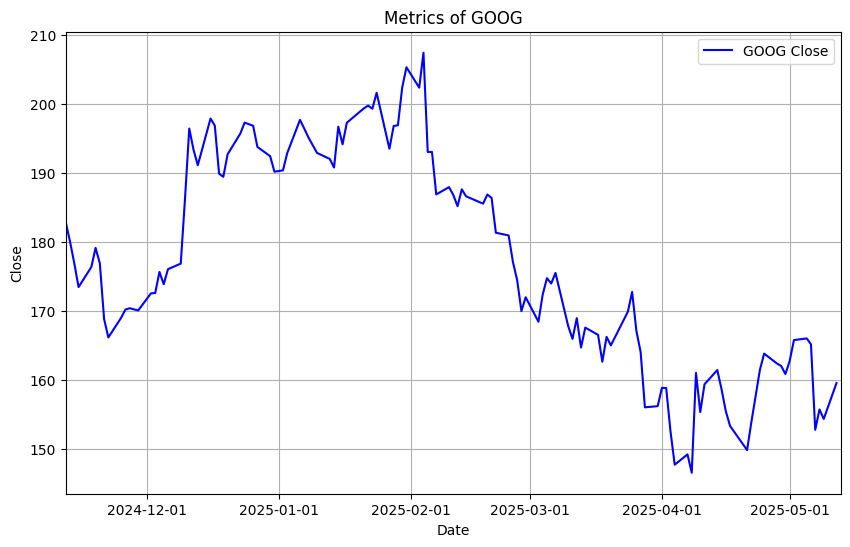

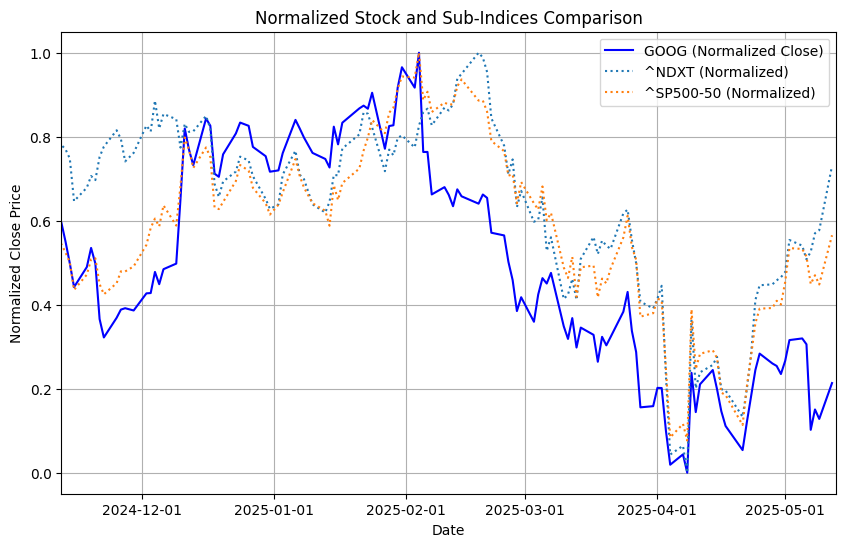

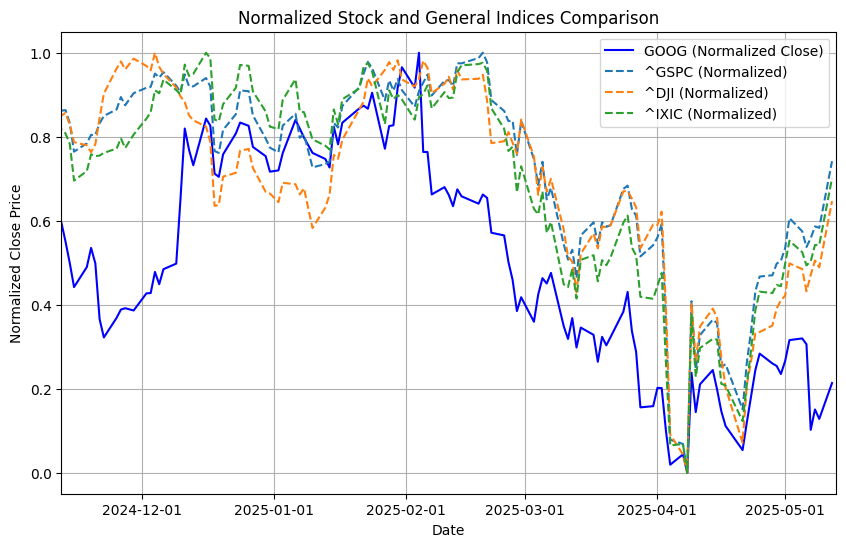

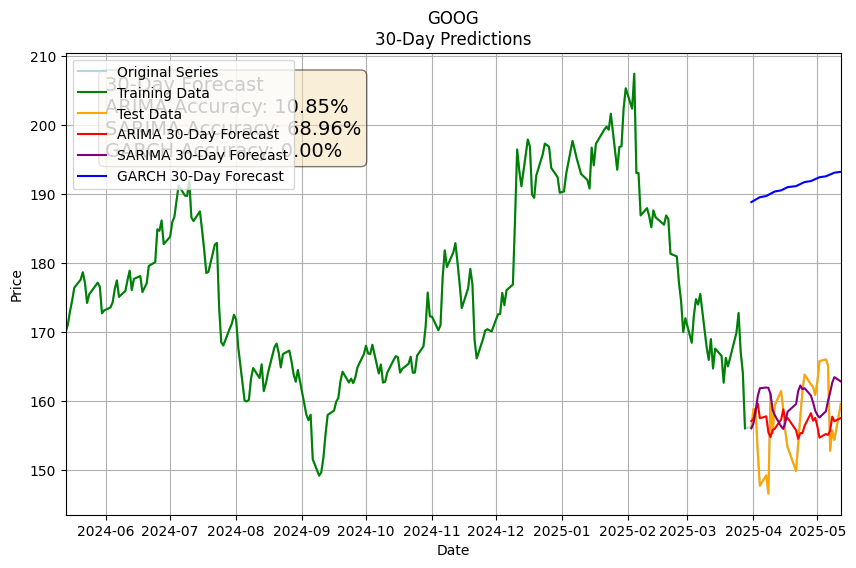

In [52]:
# Tkinter GUI Setup
root = tk.Tk()
root.title("Stock Analysis Input Form")

# Set the window size
window_width = 350
window_height = 230
root.geometry(f"{window_width}x{window_height}")

# Center the window on the screen
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()
x_coordinate = int((screen_width / 2) - (window_width / 2))
y_coordinate = int((screen_height / 2) - (window_height / 2))
root.geometry(f"{window_width}x{window_height}+{x_coordinate}+{y_coordinate}")

# Define form variables
market_type_var = tk.StringVar()
ticker_var = tk.StringVar()
start_date_var = tk.StringVar()
end_date_var = tk.StringVar()
metrics_var = tk.StringVar()
p_var = tk.IntVar()
d_var = tk.IntVar()
q_var = tk.IntVar()

# Create and place form fields
ttk.Label(root, text="Market Type (US/International):").grid(row=0, column=0, padx=10, pady=5)
market_type_dropdown = ttk.Combobox(root, textvariable=market_type_var, values=["US", "International"])
market_type_dropdown.grid(row=0, column=1, padx=10, pady=5)
market_type_dropdown.set("US")  # Default value

ttk.Label(root, text="Stock Ticker:").grid(row=1, column=0, padx=10, pady=5)
ticker_entry = ttk.Entry(root, textvariable=ticker_var)
ticker_entry.grid(row=1, column=1, padx=10, pady=5)

ttk.Label(root, text="Metrics (Comma-separated):").grid(row=4, column=0, padx=10, pady=5)
metrics_entry = ttk.Entry(root, textvariable=metrics_var)
metrics_entry.grid(row=4, column=1, padx=10, pady=5)

ttk.Label(root, text="p value:").grid(row=5, column=0, padx=10, pady=5)
p = ttk.Entry(root, textvariable=p_var)
p.grid(row=5, column=1, padx=10, pady=5)

ttk.Label(root, text="d value:").grid(row=6, column=0, padx=10, pady=5)
d = ttk.Entry(root, textvariable=d_var)
d.grid(row=6, column=1, padx=10, pady=5)

ttk.Label(root, text="q value:").grid(row=7, column=0, padx=10, pady=5)
q = ttk.Entry(root, textvariable=q_var)
q.grid(row=7, column=1, padx=10, pady=5)

# Submit Button
submit_button = ttk.Button(root, text="Analyze", command=process_inputs)
submit_button.grid(row=10, column=0, columnspan=2, pady=10)

# Bind arrow key navigation
for entry in [market_type_dropdown, ticker_entry, metrics_entry, p, d, q]:
    entry.bind('<Key>', navigate_fields)

root.bind('<Return>', lambda event: process_inputs())

root.mainloop()